### Problem Description

Write some details of the problem ... also mention the link of the dataset

### Import Packages

In [1]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
from bs4 import BeautifulSoup
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from nltk.stem.porter import PorterStemmer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

C:\ProgramData\Anaconda3\envs\omnya1\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
from sklearn.linear_model import LogisticRegression,SGDClassifier

### Read Dataset

In [3]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 7.36 s


In [4]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [5]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [6]:
df_text.duplicated().sum()

174779

In [7]:
## Write your code here
df_text.drop_duplicates(inplace=True)
df_text.duplicated().sum()

0

In [8]:
df_text.reset_index(drop=True, inplace=True)

In [9]:
df_text.shape

(393675, 2)

### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [10]:
df_text['target'] = df_text['Score'].apply(lambda x: 1 if x>3 else 0)

In [11]:
df_text.head(5)

,Text,Score,target
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


#### Plot Countplot for target Variable

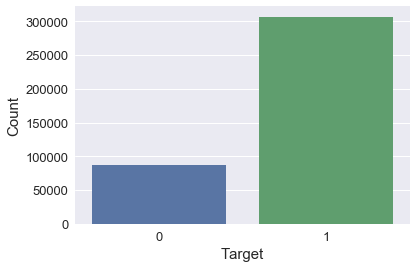

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_text.target)

plt.ylabel("Count", fontsize=15);
plt.xlabel("Target", fontsize=15);

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [13]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])

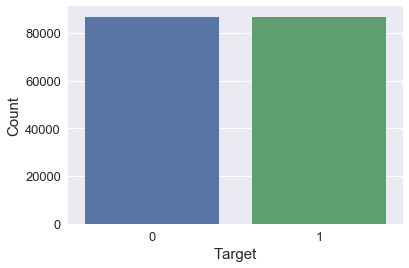

In [14]:
## PLot the target again after balancing
## Write your code here
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_text_balanced.target)

plt.ylabel("Count", fontsize=15);
plt.xlabel("Target", fontsize=15);

### Text Pre-Processing

In [15]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [16]:
## Clean your reviews using stemmer, lemmatizer & stopwords

In [17]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def decontract(sentence):
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def remove_between_square_brackets(text):    # Removing the square brackets
    return re.sub('\[[^]]*\]', '', text) 

def remove_between_square_brackets(text):    # Removing URL's
    return re.sub(r'http\S+', '', text)

def cleanPunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def denoise_text(text):                      # Removing the noisy text
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = cleanPunc(text)
    text = decontract(text)

    return text
#Apply function on review column
df_text_balanced['Text']=df_text_balanced['Text'].apply(denoise_text)

In [18]:
stemmer = PorterStemmer()
def stem_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop_words:
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)

In [19]:
df_text_balanced.Text = df_text_balanced.Text.apply(stem_text)

In [20]:
df_text_balanced.shape

(173712, 3)

### Split Test & Training Data

In [21]:
X = df_text_balanced['Text'] ## Write your code here
y = df_text_balanced['target'] ## Write your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [22]:
# TFIDF embedding for the Description
vectorizer = TfidfVectorizer() ## Write your code here
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X) ## Write your code here
# transform on training data
X_train =  vectorizer.transform(X_train) ## Write your code here
# transform on testing data
X_test =  vectorizer.transform(X_test) ## Write your code here

In [23]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((121598, 77127), (52114, 77127))

### Modelling

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [25]:
## initialize your Model
clf = RandomForestClassifier(n_estimators=20, random_state=0)
# Fit your Model on the Training Dataset
clf_fit = clf.fit(X_train,y_train)
# Predict on Test data
preds = clf_fit.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 79.2%


### Raw Instance Prediction

In [26]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = denoise_text(review)
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = int(clf.predict(embedding.reshape(1,-1)))
    return "Positive" if prediction == 1 else "Negative"

In [27]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [28]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [29]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [30]:
import pickle

In [32]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'

with open("rf_model.pkl", "wb") as f1:
    pickle.dump(clf, f1)

with open("tfidf_vectorizer.pkl", "wb") as f2:
    pickle.dump(vectorizer, f2)
    


### Load model Again and test them

In [33]:
loaded_model = pickle.load(open("rf_model.pkl", 'rb'))
loaded_vect = pickle.load(open("tfidf_vectorizer.pkl", 'rb'))


In [34]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [35]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [36]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

# Great Job !
### Now Deploy your ML model using Streamlit Framework